# Introduction

Image-to-image translation is a fundamental task in computer vision that focuses on converting an image from one domain into a corresponding image in another. This project explores the use of **Cycle-Consistent Generative Adversarial Networks (CycleGANs)** for translating images between two visually distinct animals: cats and dogs. This tasks is more difficult than translating between two similar animals due to the differences in shape, texture, facial structure, fur patterns and other distinct features between cats and dogs. Unlike traditional methods requiring paired datasets, where an image of a cat is directly matched with an equivalent image of a dog, CycleGANs enable unpaired image-to-image translation, making them a great fit for this project.

The primary objective is to develop a model capable of transforming an image of a cat into an image of a dog, and vice versa, while preserving important attributes such as pose, orientation, and background context. Achieving this requires not only generating realistic textures and colors but also ensuring structural consistency between the input and output images.

For this project, I will utilize the **Kaggle Cats and Dogs dataset**, which provides a large collection of images containing various breeds, poses, lighting conditions, and backgrounds. This dataset introduces real-world variability, challenging the model to generalize across diverse scenarios.

**Project Goals:**

- Preprocessing: Efficiently process and augment the dataset to ensure the model receives high-quality and diverse input images.
- Model Architecture: Implement the CycleGAN framework, which consists of two generators (for cat-to-dog and dog-to-cat translation) and two discriminators (to distinguish real and generated images).
- Training Procedure: Train the CycleGAN using cycle-consistency loss, adversarial loss, and identity loss to ensure stable learning and realistic outputs.
- Evaluation: Assess the model’s performance both qualitatively, through visual inspection of translated images, and quantitatively using appropriate metrics.
- Challenges & Limitations: Address common issues such as mode collapse, training instability, and difficulties in capturing fine-grained details.


In [14]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers
import PIL
import seaborn as sns
import optuna

# Use GPU if available
gpu = tf.config.list_physical_devices("GPU")[0]
print(gpu)
# Set GPU memory growth
try:
    tf.config.experimental.set_memory_growth(gpu, True)
except RuntimeError as e:
    print(e)

try:
    strategy = tf.distribute.MirroredStrategy()
    print("Number of devices: {}".format(strategy.num_replicas_in_sync))
except:
    strategy = tf.distribute.get_strategy()


AUTOTUNE = tf.data.AUTOTUNE

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


# Data

For this project, I am using the [Kaggle Cat vs Dog Dataset](https://www.kaggle.com/datasets/karakaggle/kaggle-cat-vs-dog-dataset/data) on Kaggle.

## Overview

The dataset contains a collection of **25,000 images** of cats and dogs, with **12,500 images per class**. Each image varies in size, breed, pose, and lighting conditions, providing a rich and diverse dataset ideal for training deep learning models. Images are named in the format `#.jpg"`, where `#` represents the image index relative to the `Cat` or `Dog` directory.

## Key Features

- **Balanced Classes:** Equal representation of cats and dogs means unbiased training.
- **Diverse Images:** Includes various cat and dog breeds with differences in fur color, texture, and facial structures.
- **Variability in Conditions:** Images come with varying backgrounds, poses, and lighting, enabling the model to generalize to real-world scenarios.
- **High Resolution:** Images are high-quality but will be resized for model compatibility during preprocessing.

## Dataset Structure

The dataset is broken into two directories in the following structure:

- Cat
  - 1.jpg
  - 2.jpg
  - ...
- Dog
  - 1.jpg
  - 2.jpg
  - ...


# Preprocessing

To prepare the dataset for CycleGAN training, the following preprocessing steps will be performed:

1. **Resizing:** Standardize all images to a consistent resolution (e.g., 256x256 pixels).
2. **Normalization:** Scale pixel values to the range [-1, 1] to improve model convergence.
3. **Data Augmentation:** Apply random flips, rotations, and color adjustments to increase dataset diversity and improve model robustness.
4. **Splitting:** Divide the dataset into training and validation sets to monitor model performance and prevent overfitting.


In [15]:
IMAGE_SIZE = (256, 256)


def get_files(folder):
    """Get files from a specified folder in the data directory."""
    files = tf.io.gfile.glob(os.path.join("data", folder, "*.jpg"))
    print(f"{folder.capitalize()} Files: {len(files)}")
    return files


def process_image(image_bytes, training=True):
    """Decode, preprocess, and augment an image."""
    image = tf.image.decode_jpeg(image_bytes, channels=3)
    image.set_shape([None, None, 3])  # Ensure the image has 3 channels
    image = tf.image.resize(image, [286, 286])  # Resize for random cropping

    if training:
        image = tf.image.random_crop(image, size=[*IMAGE_SIZE, 3])
        image = tf.image.random_flip_left_right(image)
        # image = tf.image.random_brightness(image, max_delta=0.2)
        # image = tf.image.random_contrast(image, 0.8, 1.2)
        image = tf.image.random_flip_up_down(image)
    else:
        image = tf.image.resize_with_crop_or_pad(image, *IMAGE_SIZE)

    image = tf.cast(image, tf.float32) / 127.5 - 1.0  # Normalize to [-1, 1]
    return image


def build_dataset(files, batch_size=1, training=True):
    """Create a batched dataset with augmentation and prefetching."""
    ds = tf.data.Dataset.from_tensor_slices(files)
    ds = ds.shuffle(buffer_size=len(files), seed=42) if training else ds
    ds = ds.map(lambda x: tf.io.read_file(x), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.map(
        lambda x: process_image(x, training=training),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)


# Verify image integrity
def is_valid_image(file_path):
    try:
        with PIL.Image.open(file_path) as img:
            img.verify()
        return True
    except (IOError, SyntaxError):
        print(f"Corrupt image detected: {file_path}")
        return False


# Filter files
cat_files = [file for file in get_files("Cat") if is_valid_image(file)]
dog_files = [file for file in get_files("Dog") if is_valid_image(file)]
cat_ds = build_dataset(cat_files, batch_size=1)
dog_ds = build_dataset(dog_files, batch_size=1)

Cat Files: 12499
Dog Files: 12499


# Show sample images from each dataset


2025-02-23 18:25:47.860587: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


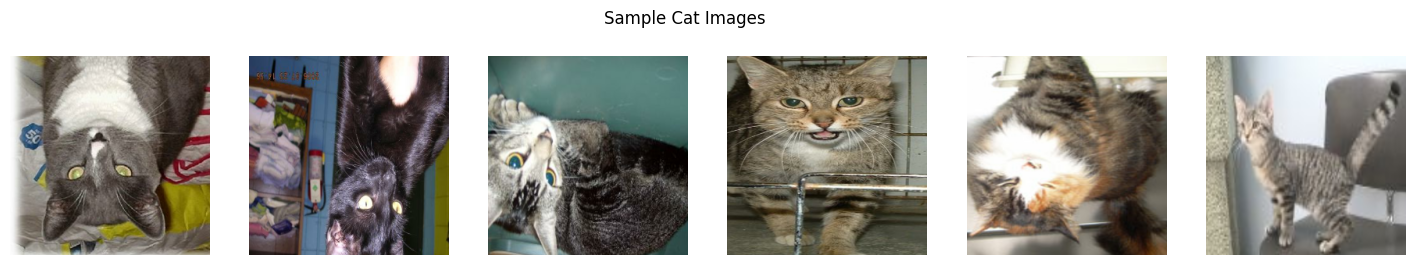

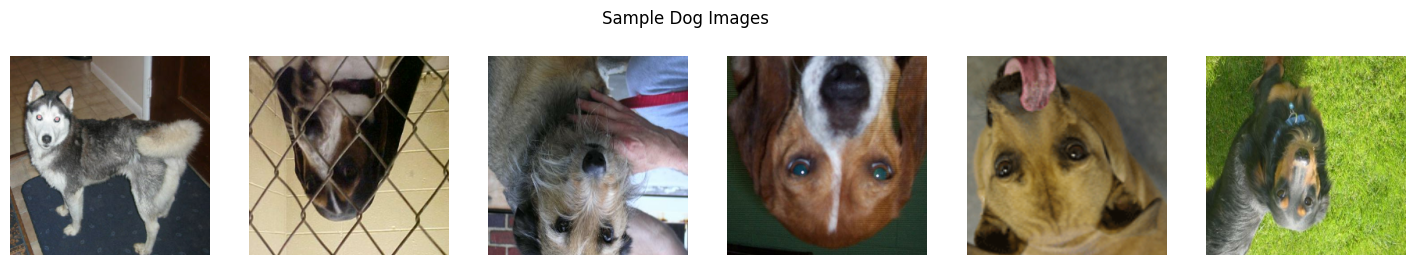

In [16]:
# Function to get a batch of images from a dataset
def get_sample_images(dataset, num_batches=10):
    images = []
    for image in dataset.take(num_batches):
        images.append(image[0].numpy())
    return np.array(images)


# Function to plot a grid of images
def plot_image_grid(images, title, grid_shape=(1, 6)):
    fig, axes = plt.subplots(
        grid_shape[0], grid_shape[1], figsize=(grid_shape[1] * 3, grid_shape[0] * 3)
    )
    fig.suptitle(title)
    for i, ax in enumerate(axes.flat):
        if i < images.shape[0]:
            # Convert pixel range from [-1,1] to [0,1] for display
            img = (images[i] * 0.5 + 0.5).astype(np.float32)
            img = np.clip(img, 0, 1)
            ax.imshow(img)
        ax.axis("off")
    plt.show()


# Plot image grids
sample_cats = get_sample_images(cat_ds)
sample_dogs = get_sample_images(dog_ds)
plot_image_grid(sample_cats, "Sample Cat Images")
plot_image_grid(sample_dogs, "Sample Dog Images")

# EDA


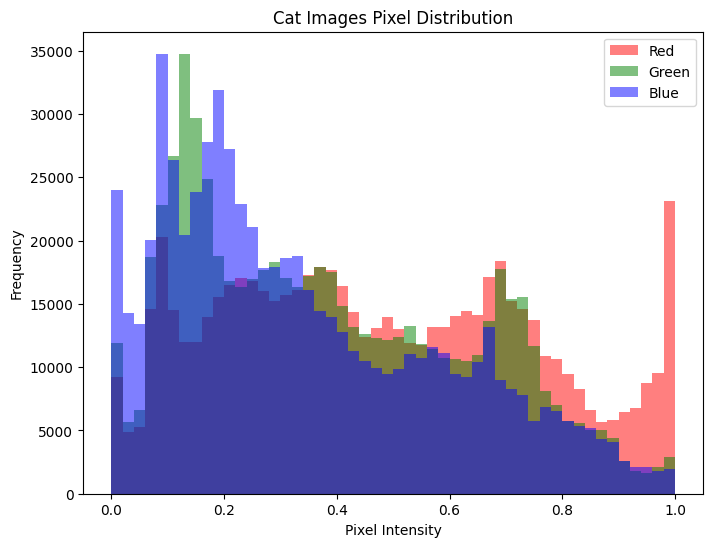

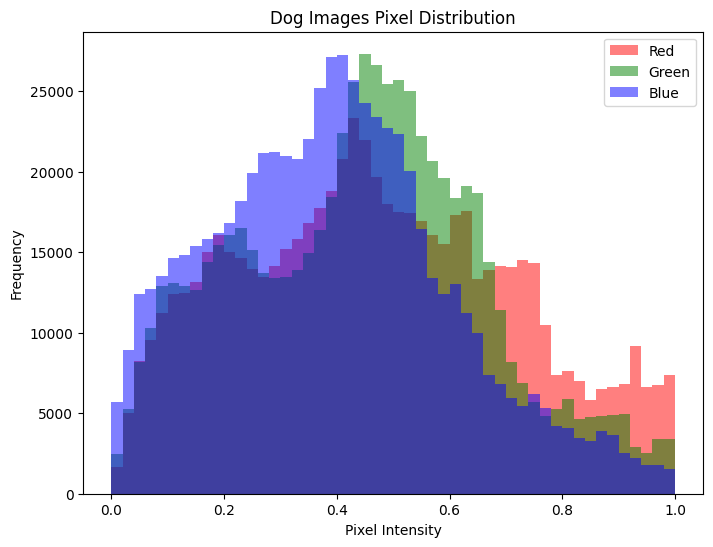

In [17]:
# Function to plot per-channel histograms
def plot_channel_histograms(images, title):
    # Convert images from [-1,1] to [0,1]
    images = images * 0.5 + 0.5
    channels = ["Red", "Green", "Blue"]
    colors = ["r", "g", "b"]

    plt.figure(figsize=(8, 6))
    for i, color in enumerate(colors):
        channel_data = images[:, :, :, i].flatten()
        plt.hist(channel_data, bins=50, alpha=0.5, color=color, label=channels[i])
    plt.title(title)
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()


# Function to compute and print mean and standard deviation
def compute_stats(images):
    # Convert images from [-1,1] to [0,1]
    images = images * 0.5 + 0.5
    mean = np.mean(images, axis=(0, 1, 2))
    std = np.std(images, axis=(0, 1, 2))
    return mean, std


sample_dogs = get_sample_images(dog_ds)
sample_cats = get_sample_images(cat_ds)

# Plot channel histograms
plot_channel_histograms(sample_cats, "Cat Images Pixel Distribution")
plot_channel_histograms(sample_dogs, "Dog Images Pixel Distribution")

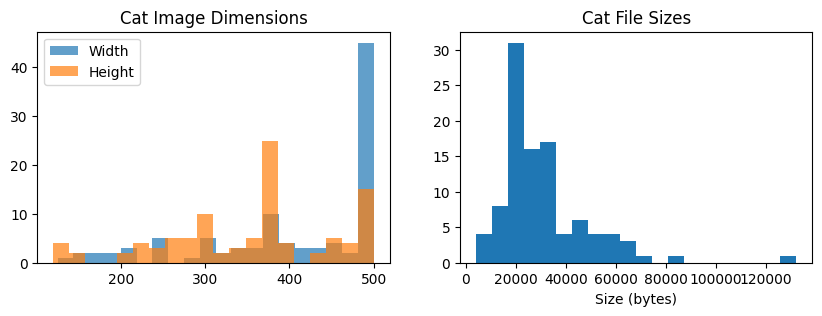

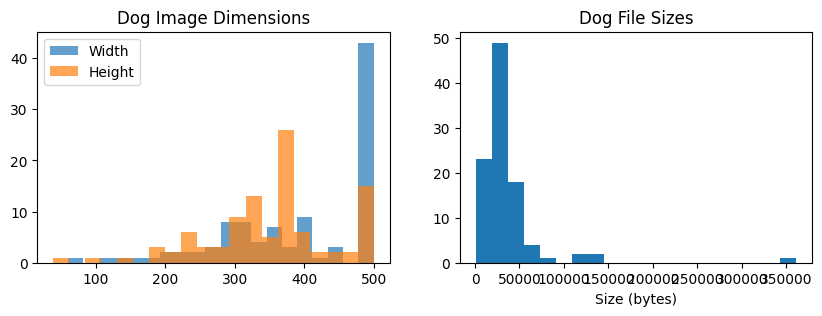

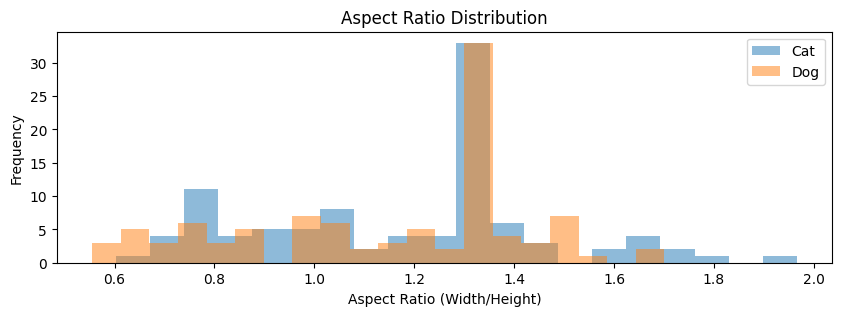

In [18]:
def dataset_summary(files, folder):
    image_sizes = []
    file_sizes = []

    for file in files[:100]:  # Sample for speed
        with PIL.Image.open(file) as img:
            image_sizes.append(img.size)
            file_sizes.append(os.path.getsize(file))

    # Plot image dimension distributions and file size distribution
    widths, heights = zip(*image_sizes)
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))

    axes[0].hist(widths, bins=20, alpha=0.7, label="Width")
    axes[0].hist(heights, bins=20, alpha=0.7, label="Height")
    axes[0].legend()
    axes[0].set_title(f"{folder} Image Dimensions")

    axes[1].hist(file_sizes, bins=20)
    axes[1].set_title(f"{folder} File Sizes")
    axes[1].set_xlabel("Size (bytes)")
    plt.show()


dataset_summary(cat_files, "Cat")
dataset_summary(dog_files, "Dog")


def aspect_ratio_analysis(files, folder):
    ratios = []
    for file in files[:100]:
        with PIL.Image.open(file) as img:
            width, height = img.size
            ratios.append(width / height)
    return ratios


cat_ratios = aspect_ratio_analysis(cat_files, "Cat")
dog_ratios = aspect_ratio_analysis(dog_files, "Dog")

plt.figure(figsize=(10, 3))
plt.hist(cat_ratios, bins=20, alpha=0.5, label="Cat")
plt.hist(dog_ratios, bins=20, alpha=0.5, label="Dog")
plt.title("Aspect Ratio Distribution")
plt.xlabel("Aspect Ratio (Width/Height)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# CycleGAN


# Generator


In [19]:
def residual_block(x, filters, kernel_size=(3, 3), strides=(1, 1), use_bias=False):
    """Defines a residual block with two convolutional layers."""
    res = x
    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding="same", use_bias=use_bias
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding="same", use_bias=use_bias
    )(x)
    x = layers.BatchNormalization()(x)

    return layers.add([x, res])  # Skip connection


def build_generator(image_shape=(256, 256, 3), num_res_blocks=9):
    """Builds the ResNet-based CycleGAN generator model."""
    inputs = layers.Input(shape=image_shape)

    # Initial convolution block
    x = layers.Conv2D(64, (7, 7), strides=(1, 1), padding="same", use_bias=False)(
        inputs
    )
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Downsampling layers
    x = layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(256, (3, 3), strides=(2, 2), padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Residual blocks
    for _ in range(num_res_blocks):
        x = residual_block(x, 256)

    # Upsampling layers
    x = layers.Conv2DTranspose(
        128, (3, 3), strides=(2, 2), padding="same", use_bias=False
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(
        64, (3, 3), strides=(2, 2), padding="same", use_bias=False
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Output layer
    outputs = layers.Conv2D(
        3, (7, 7), strides=(1, 1), padding="same", activation="tanh"
    )(x)

    return tf.keras.Model(inputs, outputs, name="CycleGAN_Generator")


generator = build_generator()

# Discriminator


In [20]:
def discriminator_block(x, filters, kernel_size=(4, 4), strides=(2, 2), use_norm=True):
    """Discriminator convolutional block with optional BatchNorm and LeakyReLU."""
    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding="same", use_bias=not use_norm
    )(x)
    if use_norm:
        x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    return x


def build_discriminator(image_shape=(256, 256, 3)):
    """Builds the PatchGAN discriminator for CycleGAN."""
    inputs = layers.Input(shape=image_shape)

    # First layer (no batch normalization as per the original CycleGAN paper)
    x = layers.Conv2D(64, (4, 4), strides=(2, 2), padding="same")(inputs)
    x = layers.LeakyReLU(alpha=0.2)(x)

    # Downsampling layers
    x = discriminator_block(x, 128, strides=(2, 2))
    x = discriminator_block(x, 256, strides=(2, 2))
    x = discriminator_block(
        x, 512, strides=(1, 1)
    )  # stride of 1 to keep spatial dimensions stable

    # Output layer: a 1-channel feature map (real or fake decision for each patch)
    outputs = layers.Conv2D(1, (4, 4), strides=(1, 1), padding="same")(x)

    return tf.keras.Model(inputs, outputs, name="CycleGAN_Discriminator")


discriminator = build_discriminator()

# CycleGAN w/ Loss Functions


In [21]:
# ---------------------------
# Loss Functions
# ---------------------------
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def discriminator_loss(real, generated):
    """Calculates the loss for the discriminator."""
    real_loss = loss_obj(tf.ones_like(real), real)  # Real images -> 1
    generated_loss = loss_obj(tf.zeros_like(generated), generated)  # Fake images -> 0
    return (real_loss + generated_loss) * 0.5


def generator_loss(generated):
    """Adversarial loss for the generator."""
    return loss_obj(
        tf.ones_like(generated), generated
    )  # Generator wants D to predict 1


def cycle_consistency_loss(real_image, cycled_image, LAMBDA=10):
    """Cycle consistency loss (L1) to ensure reconstructed images are close to originals."""
    return LAMBDA * tf.reduce_mean(tf.abs(real_image - cycled_image))


def identity_loss(real_image, same_image, LAMBDA=10):
    """Identity loss to preserve color and lighting."""
    return LAMBDA * 0.5 * tf.reduce_mean(tf.abs(real_image - same_image))


# ---------------------------
# Build Generators and Discriminators
# ---------------------------
generator_g = build_generator()  # X → Y
generator_f = build_generator()  # Y → X

discriminator_x = build_discriminator()  # D_X: real/fake X
discriminator_y = build_discriminator()  # D_Y: real/fake Y


# ---------------------------
# Optimizers
# ---------------------------
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


# ---------------------------
# Training Step
# ---------------------------
@tf.function
def train_step(real_x, real_y, LAMBDA=10):
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X → Y
        fake_y = generator_g(real_x, training=True)
        # Generator F translates Y → X
        fake_x = generator_f(real_y, training=True)

        # Cycle consistency
        cycled_x = generator_f(fake_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # Identity mapping
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        # Assert shapes match before computing losses
        tf.debugging.assert_equal(
            tf.shape(real_x),
            tf.shape(cycled_x),
            message="Shape mismatch: real_x and cycled_x",
        )
        tf.debugging.assert_equal(
            tf.shape(real_y),
            tf.shape(cycled_y),
            message="Shape mismatch: real_y and cycled_y",
        )
        tf.debugging.assert_equal(
            tf.shape(real_y),
            tf.shape(same_y),
            message="Shape mismatch: real_y and same_y",
        )
        tf.debugging.assert_equal(
            tf.shape(real_x),
            tf.shape(same_x),
            message="Shape mismatch: real_x and same_x",
        )

        # Discriminator predictions
        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)
        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # Calculate losses
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = cycle_consistency_loss(
            real_x, cycled_x, LAMBDA
        ) + cycle_consistency_loss(real_y, cycled_y, LAMBDA)
        id_loss_g = identity_loss(real_y, same_y, LAMBDA)
        id_loss_f = identity_loss(real_x, same_x, LAMBDA)

        total_gen_g_loss = gen_g_loss + total_cycle_loss + id_loss_g
        total_gen_f_loss = gen_f_loss + total_cycle_loss + id_loss_f

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Apply gradients
    generator_g_gradients = tape.gradient(
        total_gen_g_loss, generator_g.trainable_variables
    )
    generator_f_gradients = tape.gradient(
        total_gen_f_loss, generator_f.trainable_variables
    )
    discriminator_x_gradients = tape.gradient(
        disc_x_loss, discriminator_x.trainable_variables
    )
    discriminator_y_gradients = tape.gradient(
        disc_y_loss, discriminator_y.trainable_variables
    )

    generator_g_optimizer.apply_gradients(
        zip(generator_g_gradients, generator_g.trainable_variables)
    )
    generator_f_optimizer.apply_gradients(
        zip(generator_f_gradients, generator_f.trainable_variables)
    )
    discriminator_x_optimizer.apply_gradients(
        zip(discriminator_x_gradients, discriminator_x.trainable_variables)
    )
    discriminator_y_optimizer.apply_gradients(
        zip(discriminator_y_gradients, discriminator_y.trainable_variables)
    )

    return {
        "gen_g_loss": total_gen_g_loss,
        "gen_f_loss": total_gen_f_loss,
        "disc_x_loss": disc_x_loss,
        "disc_y_loss": disc_y_loss,
    }


# ---------------------------
# Training Loop
# ---------------------------
def train_cycle_gan(dataset_x, dataset_y, epochs=5, LAMBDA=10):
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        for real_x, real_y in zip(dataset_x, dataset_y):
            losses = train_step(real_x, real_y, LAMBDA)

        print(
            f"gen_g_loss: {losses['gen_g_loss']:.4f}, gen_f_loss: {losses['gen_f_loss']:.4f}, "
            f"disc_x_loss: {losses['disc_x_loss']:.4f}, disc_y_loss: {losses['disc_y_loss']:.4f}"
        )

In [22]:
# Baseline training
train_cycle_gan(cat_ds, dog_ds, epochs=1)

Epoch 1/1


InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_1_device_/job:localhost/replica:0/task:0/device:CPU:0}} Trying to decode BMP format using a wrong op. Use `decode_bmp` or `decode_image` instead. Op used: DecodeJpeg
	 [[{{node DecodeJpeg}}]] [Op:IteratorGetNext] name: 

In [ ]:
# Visualization of Initial Results


def visualize_translation(model, dataset, num_images=5):
    """
    Visualizes the translation results from the model.

    Parameters:
    - model: Trained image translation model.
    - dataset: tf.data.Dataset containing input images.
    - num_images: Number of images to display.
    """
    sample_images = list(dataset.take(num_images))

    plt.figure(figsize=(12, num_images * 4))

    for i, img in enumerate(sample_images):
        input_img = img[0].numpy()
        input_img = input_img * 0.5 + 0.5  # Rescale from [-1, 1] to [0, 1]

        translated_img = model(tf.expand_dims(img[0], axis=0), training=False)[
            0
        ].numpy()
        translated_img = translated_img * 0.5 + 0.5  # Rescale from [-1, 1] to [0, 1]

        # Display the original image
        plt.subplot(num_images, 2, 2 * i + 1)
        plt.imshow(input_img)
        plt.title("Original Image")
        plt.axis("off")

        # Display the translated image
        plt.subplot(num_images, 2, 2 * i + 2)
        plt.imshow(translated_img)
        plt.title("Translated Image")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


visualize_translation(generator_g, cat_ds)

# Hyperparameter optimization


In [ ]:
# ---------------------------
# Helper Functions
# ---------------------------
def update_learning_rates(generator_lr, discriminator_lr):
    """Updates learning rates for all optimizers."""
    for optimizer in [generator_g_optimizer, generator_f_optimizer]:
        optimizer.learning_rate = generator_lr
    for optimizer in [discriminator_x_optimizer, discriminator_y_optimizer]:
        optimizer.learning_rate = discriminator_lr


def train_and_evaluate(generator_lr, discriminator_lr, LAMBDA_cycle, epochs=2):
    """Updates hyperparameters, runs training, and returns evaluation metric."""
    update_learning_rates(generator_lr, discriminator_lr)
    train_cycle_gan(cat_ds, dog_ds, epochs=epochs, LAMBDA=LAMBDA_cycle)
    evaluation = train_step(cat_ds.take(1), dog_ds.take(1))["gen_g_loss"]
    return evaluation


# ---------------------------
# Optuna Objective Function
# ---------------------------
def objective(trial):
    generator_lr = trial.suggest_float("generator_lr", 1e-5, 5e-4)
    discriminator_lr = trial.suggest_float("discriminator_lr", 1e-5, 5e-4)
    LAMBDA_cycle = trial.suggest_int("LAMBDA_cycle", 5, 15)
    return train_and_evaluate(generator_lr, discriminator_lr, LAMBDA_cycle, epochs=2)


# ---------------------------
# Training & Optimization Workflow
# ---------------------------

# # Step 0: Create Optuna study
# study = optuna.create_study(direction="minimize")

# # Step 1: Quick hyperparameter exploration
# study.optimize(objective, n_trials=2)

# # Step 2: Fine-tune top parameters
# study.optimize(objective, n_trials=2)

# # Step 3: Final training with best parameters
# best_params = study.best_params
# print(f"Best Hyperparameters: {best_params}")
# train_and_evaluate(
#     best_params["generator_lr"],
#     best_params["discriminator_lr"],
#     best_params["LAMBDA_cycle"],
#     epochs=1,
# )